In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import io
import bson
import matplotlib
import matplotlib.pyplot as plt
from skimage.data import imread   
import multiprocessing as mp
import numpy as np
import pandas as pd
from collections import Counter
from keras.utils import np_utils
from tflearn.data_utils import to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
import tensorflow as tf
import tflearn
import skimage
from skimage.transform import resize, rescale
from tqdm import tqdm_notebook
from sklearn.metrics import roc_curve, auc
import itertools

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
categories_names = pd.read_csv('../input/category_names.csv', index_col='category_id')

In [3]:
idProduct = []
categoryProduct = []
countProductImgs = []
totalDict = 7069896
trainPath = '../input/train.bson'

with open(trainPath, 'rb') as file, tqdm_notebook(total=totalDict) as bar:
        
    productDict = bson.decode_file_iter(file)

    for c, myDict in enumerate(productDict):
        bar.update()
        idProduct.append(myDict['_id'])
        categoryProduct.append(str(myDict['category_id']))
        countProductImgs.append(len(myDict['imgs']))

In [4]:
myDataframe = pd.DataFrame({'categoryID': categoryProduct, 'countImgs': countProductImgs}, index=idProduct)

Total Images in Train set: 12371293
Total Categories: 5270


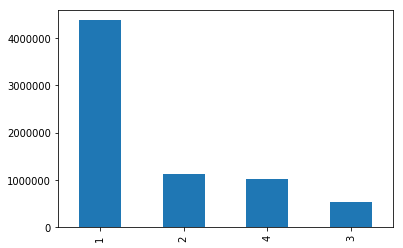

In [5]:
myDataframe.countImgs.value_counts().plot(kind='bar')
print("Total Images in Train set:", myDataframe.countImgs.sum())
print("Total Categories:", len(pd.unique(myDataframe.categoryID)))

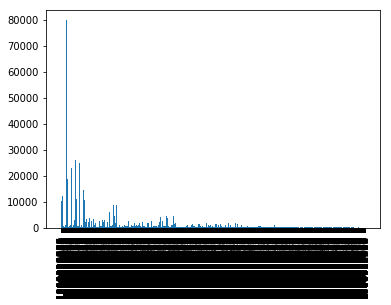

In [6]:
classLabels, count = zip(*Counter(categoryProduct).items())
indexes = np.arange(len(classLabels))
width = 1

plt.bar(indexes, count, width)
plt.xticks(indexes + width * 0.5, classLabels)
plt.xticks(rotation=90)
plt.show()

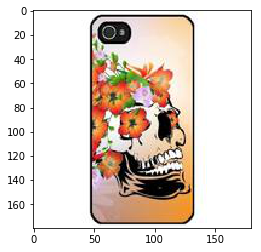

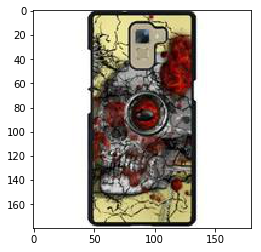

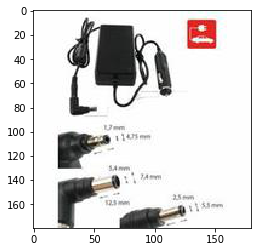

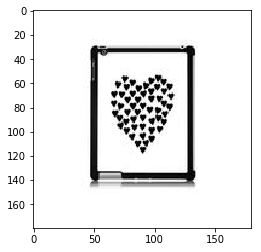

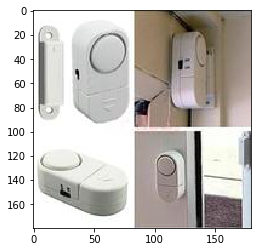

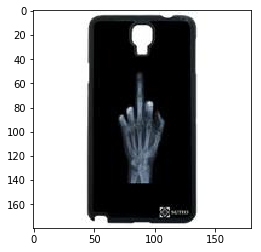

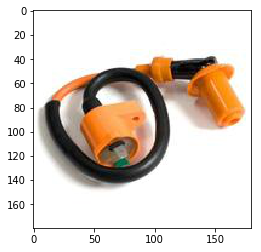

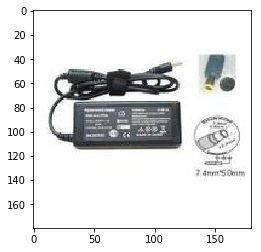

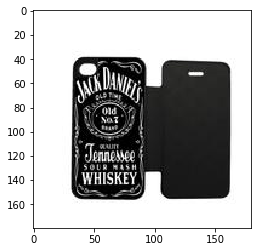

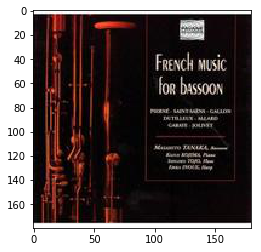

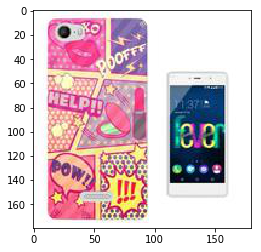

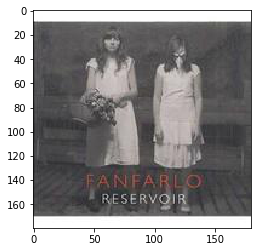

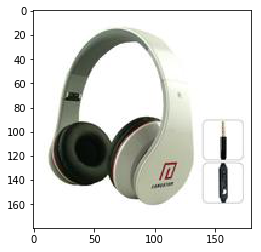

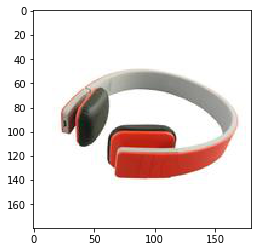

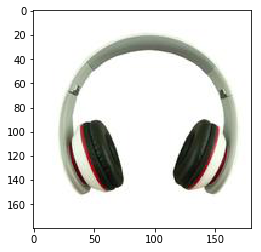

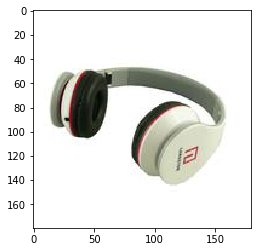

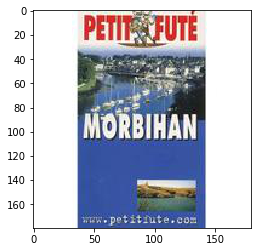

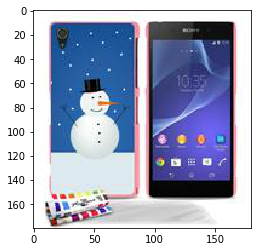

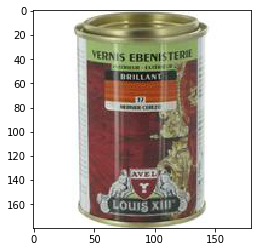

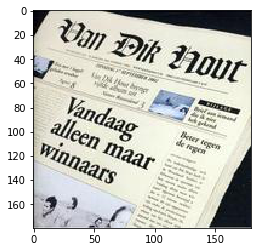

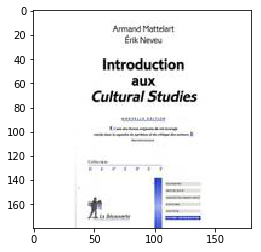

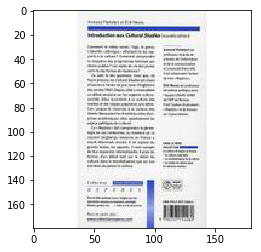

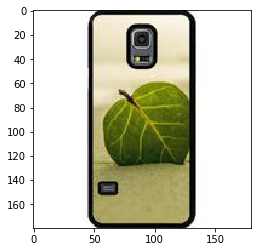

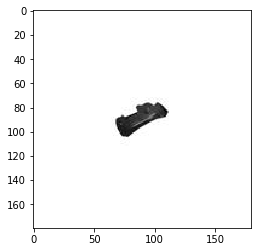

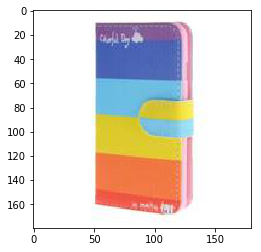

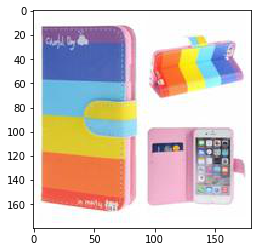

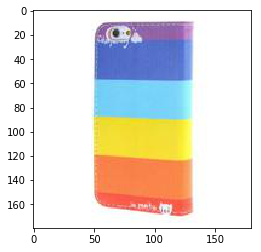

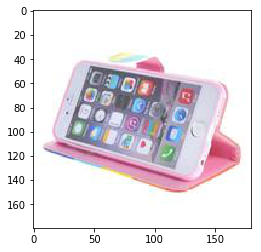

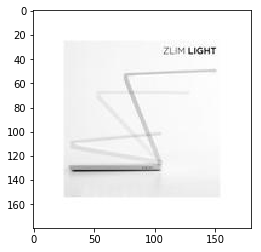

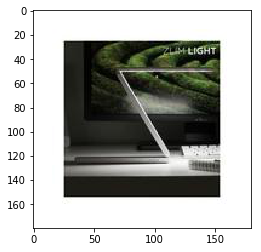

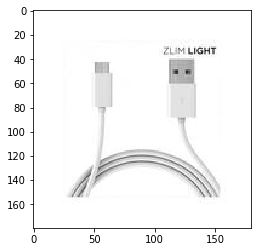

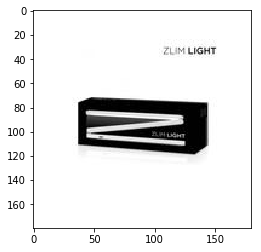

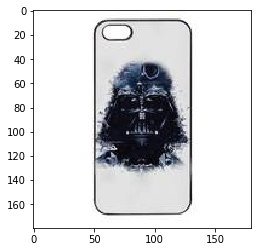

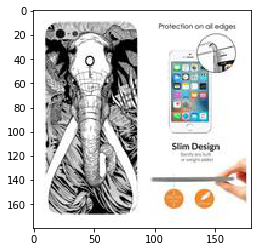

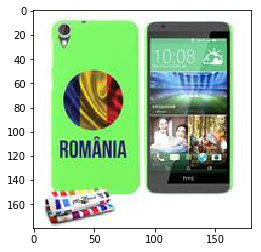

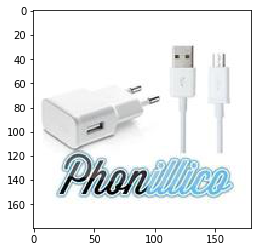

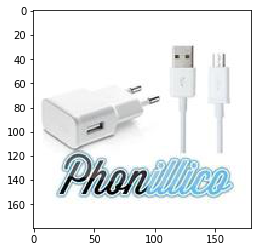

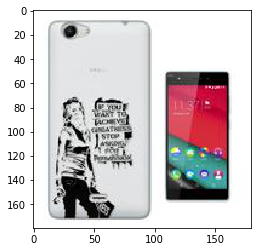

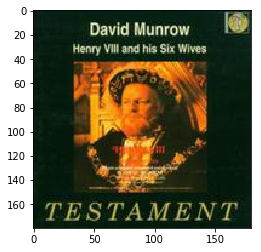

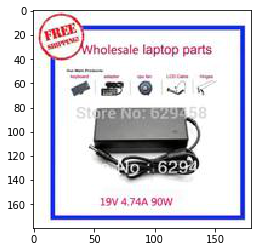

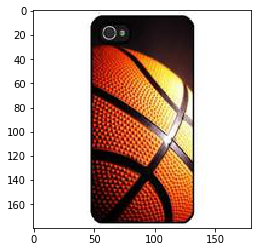

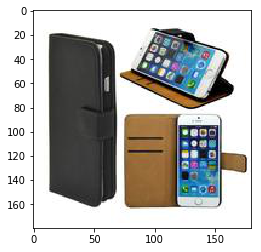

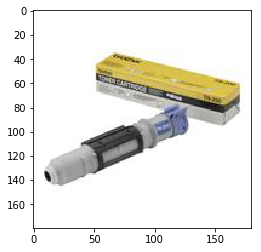

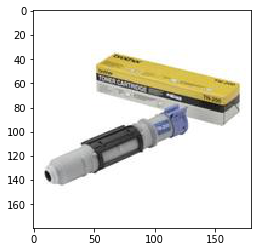

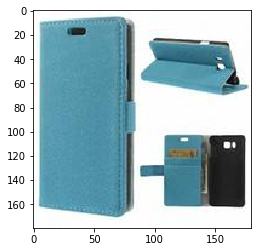

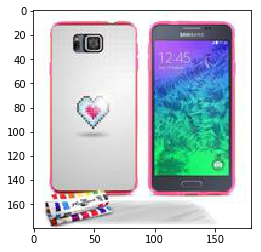

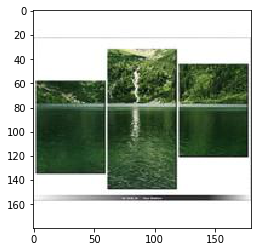

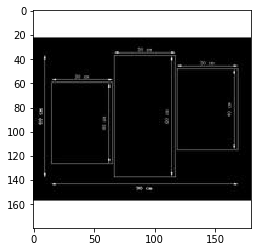

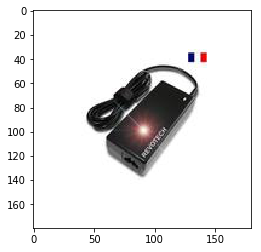

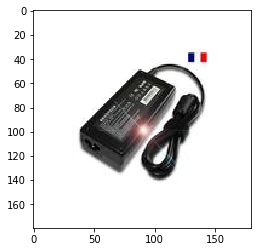

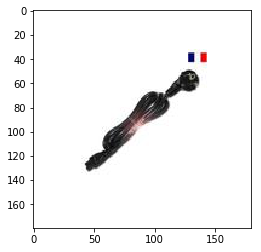

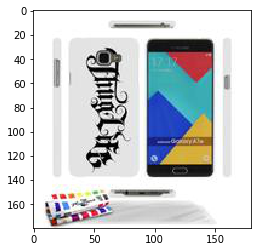

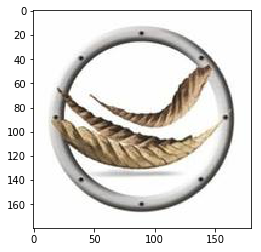

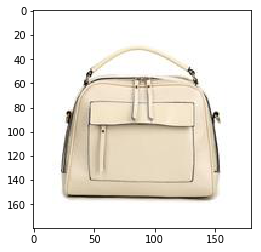

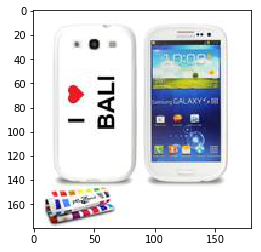

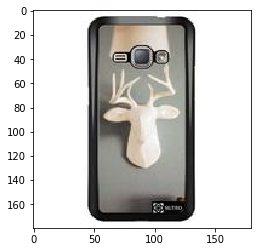

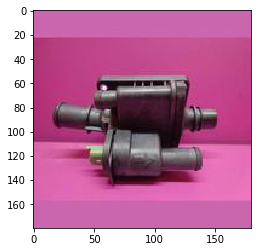

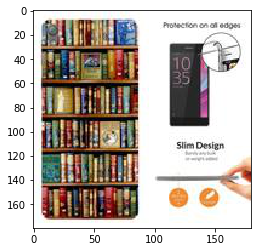

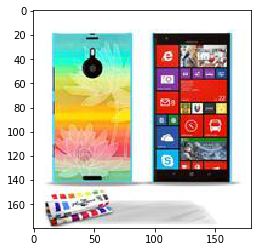

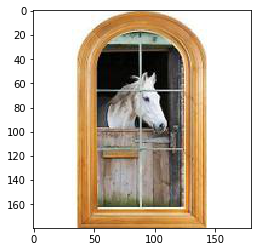

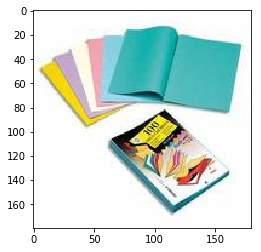

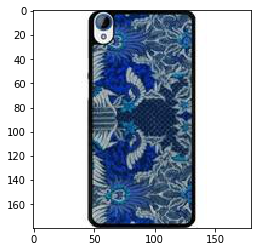

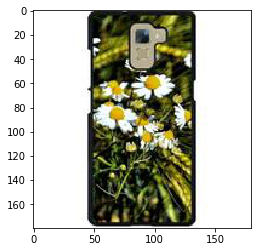

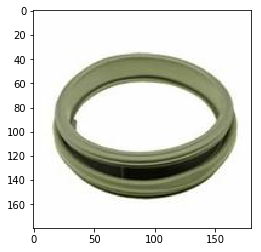

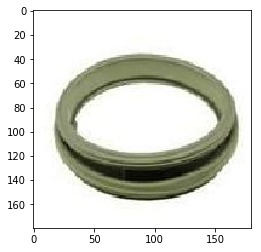

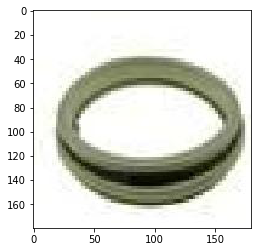

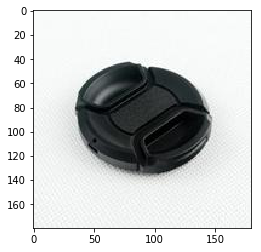

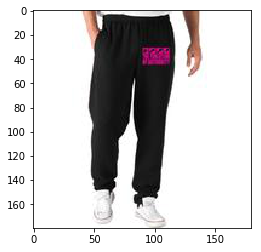

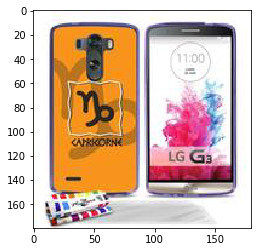

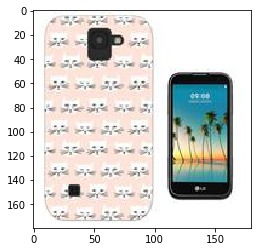

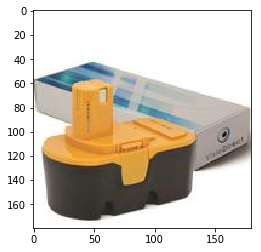

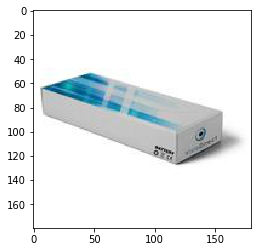

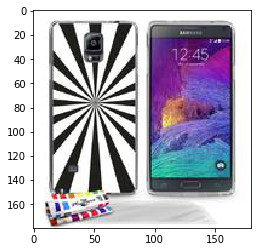

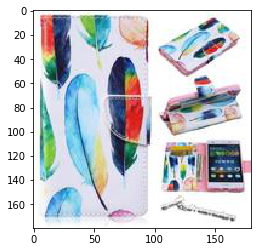

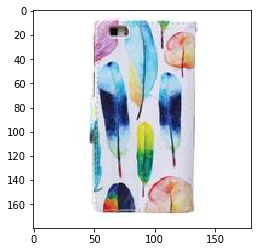

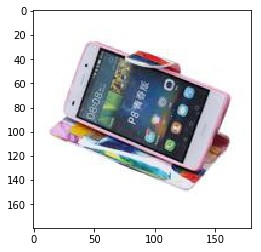

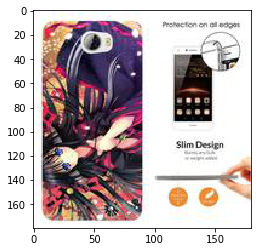

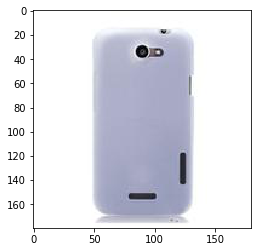

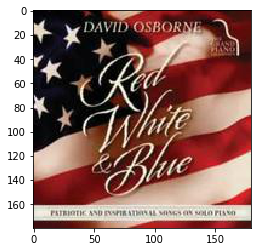

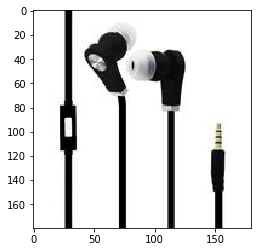

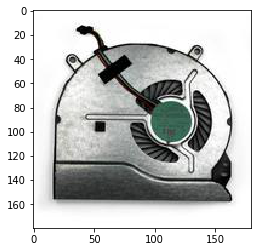

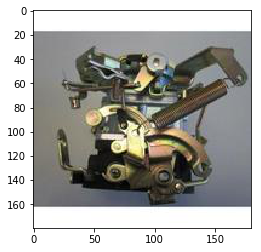

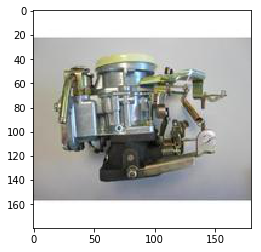

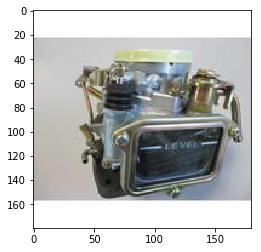

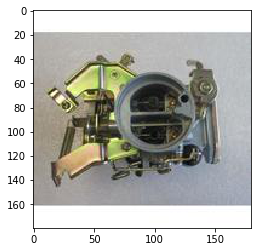

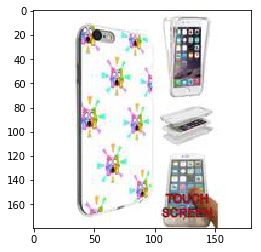

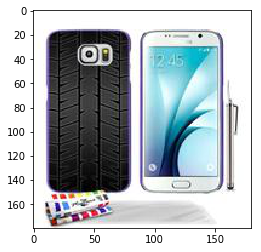

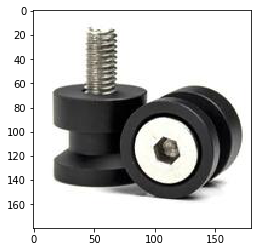

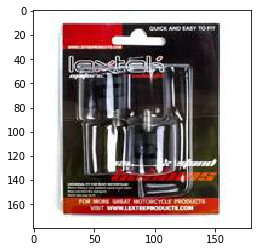

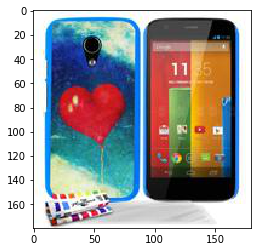

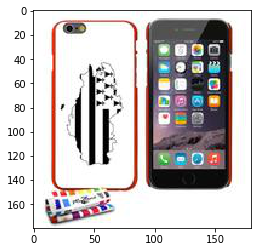

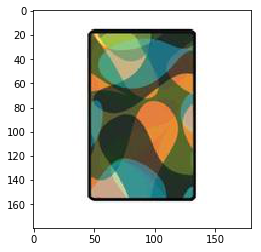

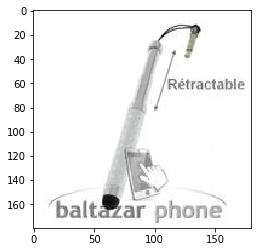

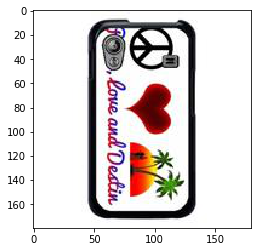

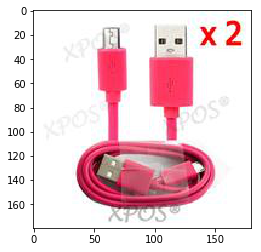

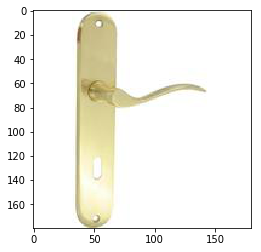

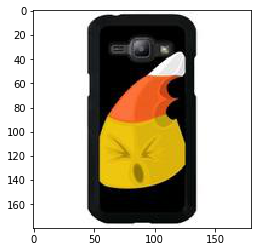

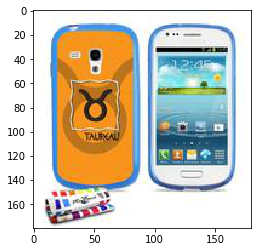

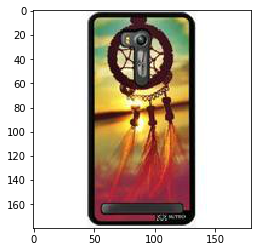

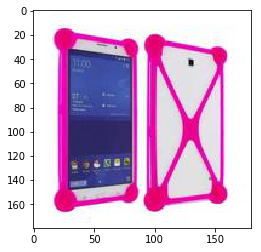

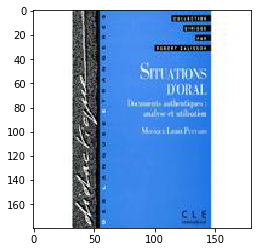

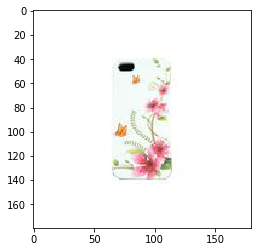

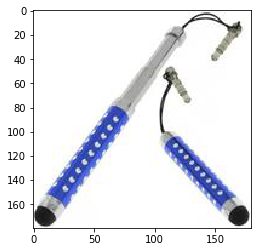

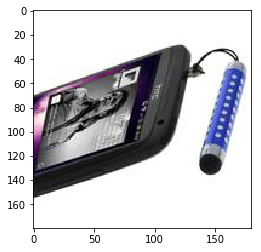

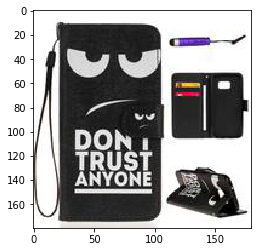

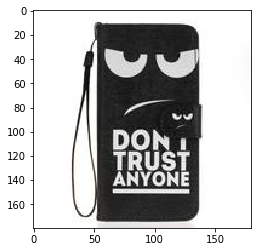

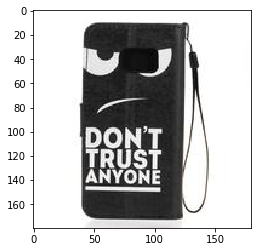

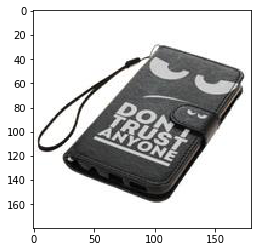

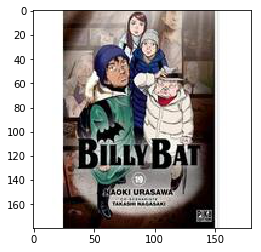

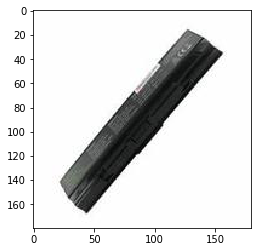

In [7]:
#visualize training sample
idProductTrain = []
categoryProductTrain = []
countProductImgsTrain = []
totalDict = 82
trainPath = '../input/train_example.bson'
picturesTrain = []
catergoryIdArray = []

with open(trainPath, 'rb') as file, tqdm_notebook(total=totalDict) as bar:
        
    productDictTrain = bson.decode_file_iter(file)

    for c, myDict in enumerate(productDictTrain):
        bar.update()
        idProductTrain.append(myDict['_id'])
        categoryProductTrain.append(str(myDict['category_id']))
        countProductImgsTrain.append(len(myDict['imgs']))
        
        for e, myPic in enumerate(myDict['imgs']):
        #display all images
            picture = imread(io.BytesIO(myPic['picture']))
            picturesTrain.append(picture)
    #         print("PRODUCT ID:", product_id, "NUMBER", e)
            plt.imshow(picture)
            plt.show()
            catergoryIdArray.append(str(myDict['category_id']))

In [8]:
def getRawFeatures(picture):
    red = [] #red channel
    green = [] #green channel
    blue = [] #blue channel
    for row in range(picture.shape[0]):
        for col in range(picture.shape[1]):
            red.append(picture[row][col][0])
            green.append(picture[row][col][1])
            blue.append(picture[row][col][2])
    feature = red
    feature.extend(green)
    feature.extend(blue)
    return feature

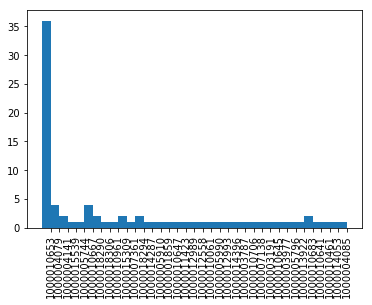

In [9]:
classLabels, count = zip(*Counter(categoryProductTrain).items())
indexes = np.arange(len(classLabels))
width = 1

plt.bar(indexes, count, width)
plt.xticks(indexes + width * 0.5, classLabels)
plt.xticks(rotation=90)
plt.show()

In [10]:
idProduct = []
categoryProduct = []
countProductImgs = []
pictures = []
catergoryIdArray = []
totalDict = 7069896
trainPath = '../input/train.bson'

with open(trainPath, 'rb') as file, tqdm_notebook(total=totalDict) as bar:
        
    productDict = bson.decode_file_iter(file)

    for c, myDict in enumerate(productDict):
        bar.update()
        idProduct.append(myDict['_id'])
        categoryProduct.append(str(myDict['category_id']))
        countProductImgs.append(len(myDict['imgs']))
        
        for e, myPic in enumerate(myDict['imgs']):
        #display all images
            picture = imread(io.BytesIO(myPic['picture']))
            image_rescaled = rescale(picture, 1.0 / 4.0)
            pictures.append(image_rescaled)
    #         print("PRODUCT ID:", product_id, "NUMBER", e)
#             plt.imshow(image_rescaled)
#             plt.show()
            catergoryIdArray.append(str(myDict['category_id']))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
X = np.asarray(pictures)
y = np.asarray(catergoryIdArray)
print(X.shape, y.shape)

#reshaping X in proper format
X = X.reshape(X.shape[0], 3, 45, 45).astype('float32')
#normalizing X
X = X - np.mean(X) / X.std()

(110, 45, 45, 3) (110,)


In [12]:
#converting class labels to One hot encoding
b,y = np.unique(y, return_inverse=True) #returns the unique values
y = np_utils.to_categorical(y) 
#y is converted to one hot representation                 

In [13]:
numClasses = len(Counter(np.asarray(catergoryIdArray)))
print(numClasses)
print(X.shape)
print(y.shape)

36
(110, 3, 45, 45)
(110, 36)


In [14]:
#lets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234) 
#spliting the data

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(82, 3, 45, 45) (82, 36) (28, 3, 45, 45) (28, 36)


In [15]:
myConvModel = input_data(shape=[None,3,45,45])

#Layer 1: Convolution and Pooling
myConvModel = conv_2d(myConvModel,45,3,activation='elu')
myConvModel = max_pool_2d(myConvModel,2)

#Layer 2 Convolution and Pooling on important features
myConvModel = conv_2d(myConvModel,100,2,activation='relu')
myConvModel = max_pool_2d(myConvModel,2)

#setting the dropout parameter to 30%
myConvModel = dropout(myConvModel,0.3)

#Layer 3 Convolution and Pooling with activation function elu
myConvModel = conv_2d(myConvModel,100,2, activation='elu')
myConvModel = max_pool_2d(myConvModel,2)

#Layer 4
myConvModel = fully_connected(myConvModel,512,activation='sigmoid')
myConvModel = dropout(myConvModel,0.3)
#Layer 5
myConvModel = fully_connected(myConvModel,numClasses,activation='softmax')
myConvModel = regression(myConvModel,optimizer='adagrad',loss='categorical_crossentropy',learning_rate=0.05)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [16]:
with tf.device('cpu:0'):
   myConvModel = tflearn.DNN(myConvModel) #Training using DNN model class
   myConvModel.fit(X_train , y_train, n_epoch=15, validation_set = (X_test, y_test), batch_size = 100) #fitting the data

Training Step: 44  | total loss: 3.35252 | time: 0.083s
| AdaGrad | epoch: 005 | loss: 3.35252 -- iter: 80/82
Training Step: 45  | total loss: 3.38539 | time: 1.097s
| AdaGrad | epoch: 005 | loss: 3.38539 | val_loss: 2.53781 -- iter: 82/82
--


In [22]:
print("Accuracy:")
myConvModel.evaluate(X_test, y_test) #Finding accuracy

Accuracy:


[0.53571426868438721]

In [18]:
y_predict = myConvModel.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


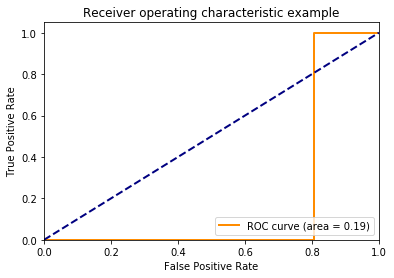

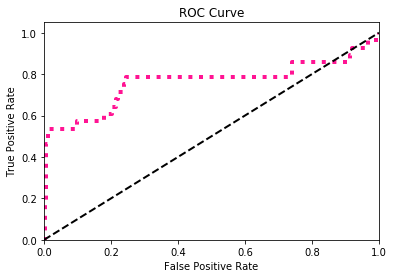

In [19]:

n_classes = 36
y_score = y_predict

# Compute ROC curve and ROC area for each class
falsePositiveRate = dict()
truePositiveRate = dict()
roc_auc = dict()
for i in range(n_classes):
    falsePositiveRate[i], truePositiveRate[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(falsePositiveRate[i], truePositiveRate[i])

# Compute micro-average ROC curve and ROC area
falsePositiveRate["micro"], truePositiveRate["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(falsePositiveRate["micro"], truePositiveRate["micro"])

plt.figure()
lw = 2
plt.plot(falsePositiveRate[2], truePositiveRate[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

all_falsePositiveRate = np.unique(np.concatenate([falsePositiveRate[i] for i in range(n_classes)]))

mean_truePositiveRate = np.zeros_like(all_falsePositiveRate)
for i in range(n_classes):
    mean_truePositiveRate += np.interp(all_falsePositiveRate, falsePositiveRate[i], truePositiveRate[i])

mean_truePositiveRate /= n_classes

falsePositiveRate["macro"] = all_falsePositiveRate
truePositiveRate["macro"] = mean_truePositiveRate
roc_auc["macro"] = auc(falsePositiveRate["macro"], truePositiveRate["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(falsePositiveRate["micro"], truePositiveRate["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [20]:
from sklearn import metrics
print("Area under the Curve:")
metrics.auc(fpr["micro"],tpr["micro"]) #Area under the curve

Area under the Curve:


0.7579810495626822

In [21]:
print('Log loss:')
metrics.log_loss(y_test, y_predict)

Log loss:


2.5378092186791554